In [ ]:
!pip install lightgbm optuna
!pip install optuna-integration[lightgbm]
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna
from optuna.integration import LightGBMPruningCallback
import sys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Senior_Thesis_Waseda/exp_Income_Level')

In [ ]:
%run ../evaluation.ipynb
%run ../training.ipynb
%run ../parameter_optimization.ipynb

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data.csv')
df.head()
df.shape

(97220, 82)

In [ ]:
income = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data_pre_cluster.csv')
income = income.loc[:, ['D_INTERVIEW','Q288']]
income.head()

,D_INTERVIEW,Q288
0,196070011,5
1,196070036,5
2,196070039,3
3,196070040,5
4,196070053,3


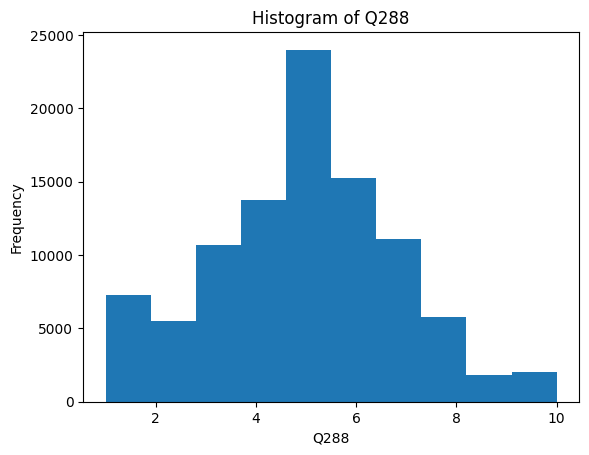

In [ ]:
import matplotlib.pyplot as plt

plt.hist(income['Q288'])
plt.xlabel('Q288')
plt.ylabel('Frequency')
plt.title('Histogram of Q288')
plt.show()

In [ ]:
df_merged = pd.merge(income, df, on='D_INTERVIEW')
df_merged.head()

,D_INTERVIEW,Q288,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,5,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,5,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
2,196070039,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.574066,0.146194,-0.200705,-0.266231,0.323946,0.268851,1,1,0,3
3,196070040,5,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,3,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3


In [ ]:
df_merged = df_merged[df_merged['Q288'] < 7]
df_merged.head()

,D_INTERVIEW,Q288,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,5,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,5,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
2,196070039,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.574066,0.146194,-0.200705,-0.266231,0.323946,0.268851,1,1,0,3
3,196070040,5,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,3,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3


In [ ]:
categorical = ['Cl_73', 'Cl_74', 'Cl_75', 'Cl_76']

for col in categorical:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [ ]:
X = df_merged.loc[:, 'Cl_1':]
y = df_merged['happiness']

In [ ]:
parameter_optimization(X, y,
    save_path="exp_Income_low_best_params.json")

[I 2025-06-14 19:36:44,204] A new study created in memory with name: lgbm_regression_opt


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.481721
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.474105
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.485784
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.483056
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.479853


[I 2025-06-14 19:48:39,037] Trial 0 finished with value: 0.4809038144750045 and parameters: {'num_leaves': 37, 'learning_rate': 0.059662768998574464, 'max_depth': 12, 'reg_alpha': 0.01689821456403644, 'reg_lambda': 0.008733286960935062, 'feature_fraction': 0.5545578611806954, 'bagging_fraction': 0.7944205512826226, 'bagging_freq': 4, 'min_data_in_leaf': 483}. Best is trial 0 with value: 0.4809038144750045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.512754
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.506616
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.51703
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.513233
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.510269


[I 2025-06-14 20:03:30,858] Trial 1 finished with value: 0.5119802428091075 and parameters: {'num_leaves': 124, 'learning_rate': 0.008135993077935482, 'max_depth': 11, 'reg_alpha': 0.00016165526881359486, 'reg_lambda': 0.7035409156988579, 'feature_fraction': 0.4019026700531766, 'bagging_fraction': 0.5756856352296862, 'bagging_freq': 5, 'min_data_in_leaf': 459}. Best is trial 0 with value: 0.4809038144750045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.996122
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.992418
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.997905
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.995333
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.993916


[I 2025-06-14 20:19:31,494] Trial 2 finished with value: 0.9951388549722482 and parameters: {'num_leaves': 59, 'learning_rate': 0.0031419355583659327, 'max_depth': 9, 'reg_alpha': 8.662924996503568, 'reg_lambda': 0.02194583099502228, 'feature_fraction': 0.47397242771581266, 'bagging_fraction': 0.9496188320394634, 'bagging_freq': 7, 'min_data_in_leaf': 153}. Best is trial 0 with value: 0.4809038144750045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.51646
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.51475
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.51547
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.51624
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.51477


[I 2025-06-14 20:28:32,703] Trial 3 finished with value: 1.5155398002896834 and parameters: {'num_leaves': 88, 'learning_rate': 0.0020393416894354194, 'max_depth': 3, 'reg_alpha': 0.004180382606157517, 'reg_lambda': 9.005175761589022, 'feature_fraction': 0.7078847726835956, 'bagging_fraction': 0.9258973847512997, 'bagging_freq': 1, 'min_data_in_leaf': 156}. Best is trial 0 with value: 0.4809038144750045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.474585
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470907
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.481329
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.475587
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.474355


[I 2025-06-14 20:46:37,701] Trial 4 finished with value: 0.4753526760826937 and parameters: {'num_leaves': 81, 'learning_rate': 0.03338461566965746, 'max_depth': 12, 'reg_alpha': 0.009228237972087388, 'reg_lambda': 4.420164028591646, 'feature_fraction': 0.6997672062599631, 'bagging_fraction': 0.8812298141809676, 'bagging_freq': 7, 'min_data_in_leaf': 251}. Best is trial 4 with value: 0.4753526760826937.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.01746
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.01227
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.01903
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.01326
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.00939


[I 2025-06-14 21:02:38,422] Trial 5 finished with value: 1.0142816936032244 and parameters: {'num_leaves': 131, 'learning_rate': 0.0035756793567883233, 'max_depth': 6, 'reg_alpha': 0.0003352532574306502, 'reg_lambda': 0.04127989591553768, 'feature_fraction': 0.7891048128108265, 'bagging_fraction': 0.9397669501941917, 'bagging_freq': 1, 'min_data_in_leaf': 169}. Best is trial 4 with value: 0.4753526760826937.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.482564
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.476617
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.488323
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.483278
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.480712


[I 2025-06-14 21:11:20,341] Trial 6 finished with value: 0.4822987766768147 and parameters: {'num_leaves': 30, 'learning_rate': 0.07511737052942642, 'max_depth': 12, 'reg_alpha': 0.0009040884568982261, 'reg_lambda': 5.889870175124454, 'feature_fraction': 0.6664289643882277, 'bagging_fraction': 0.5580546342887509, 'bagging_freq': 5, 'min_data_in_leaf': 200}. Best is trial 4 with value: 0.4753526760826937.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.472585
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.467986
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.477908
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.473277
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.471147


[I 2025-06-14 21:33:44,502] Trial 7 finished with value: 0.4725806693415654 and parameters: {'num_leaves': 149, 'learning_rate': 0.021584729121977998, 'max_depth': 12, 'reg_alpha': 7.376024827825465, 'reg_lambda': 0.0008077586571489891, 'feature_fraction': 0.6648231984664661, 'bagging_fraction': 0.8036760300859622, 'bagging_freq': 5, 'min_data_in_leaf': 204}. Best is trial 7 with value: 0.4725806693415654.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.480123
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.476213
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.484303
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.480278
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.476641


[I 2025-06-14 21:52:22,086] Trial 8 finished with value: 0.47951163784019213 and parameters: {'num_leaves': 107, 'learning_rate': 0.027521448316098446, 'max_depth': 10, 'reg_alpha': 0.004026360901338699, 'reg_lambda': 0.000305705563511273, 'feature_fraction': 0.9006505683344346, 'bagging_fraction': 0.4151335109209015, 'bagging_freq': 2, 'min_data_in_leaf': 432}. Best is trial 7 with value: 0.4725806693415654.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.31221
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.30875
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.31174
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.31118
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.30939


[I 2025-06-14 22:07:10,714] Trial 9 finished with value: 1.310652351927899 and parameters: {'num_leaves': 26, 'learning_rate': 0.0024446594456802922, 'max_depth': 7, 'reg_alpha': 0.001499402648929466, 'reg_lambda': 0.006244650388242344, 'feature_fraction': 0.4870981102803031, 'bagging_fraction': 0.4813828127928418, 'bagging_freq': 1, 'min_data_in_leaf': 92}. Best is trial 7 with value: 0.4725806693415654.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 22:07:41,172] Trial 10 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.477077
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.472489
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.483172
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.479287
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.476325


[I 2025-06-14 22:30:54,099] Trial 11 finished with value: 0.47767013996462193 and parameters: {'num_leaves': 72, 'learning_rate': 0.028114034068820244, 'max_depth': 9, 'reg_alpha': 0.18049197303944922, 'reg_lambda': 0.34512409552326406, 'feature_fraction': 0.6296645942023187, 'bagging_fraction': 0.819810144023043, 'bagging_freq': 7, 'min_data_in_leaf': 284}. Best is trial 7 with value: 0.4725806693415654.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 22:31:41,709] Trial 12 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 22:34:03,903] Trial 13 pruned. Trial was pruned at iteration 276.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 22:34:44,645] Trial 14 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 22:35:30,841] Trial 15 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.477725
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.472781
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.48345
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.478956
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.476495


[I 2025-06-14 22:59:53,892] Trial 16 finished with value: 0.4778813792713 and parameters: {'num_leaves': 54, 'learning_rate': 0.04521189109160477, 'max_depth': 10, 'reg_alpha': 0.010061145548751751, 'reg_lambda': 1.7087530489429836, 'feature_fraction': 0.8624086565552432, 'bagging_fraction': 0.9987561539929737, 'bagging_freq': 4, 'min_data_in_leaf': 355}. Best is trial 7 with value: 0.4725806693415654.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 23:00:13,884] Trial 17 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 23:00:59,922] Trial 18 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 23:01:33,982] Trial 19 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-14 23:02:03,236] Trial 20 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.474336
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469004
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.480015
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.474538
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.472522


[I 2025-06-14 23:23:38,283] Trial 21 finished with value: 0.4740830926120177 and parameters: {'num_leaves': 77, 'learning_rate': 0.039278950418040956, 'max_depth': 9, 'reg_alpha': 0.14154405943530612, 'reg_lambda': 0.2835833892843662, 'feature_fraction': 0.6345014591864532, 'bagging_fraction': 0.7960179725530865, 'bagging_freq': 7, 'min_data_in_leaf': 281}. Best is trial 7 with value: 0.4725806693415654.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.474882
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469882
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.480938
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.474769
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.47324


[I 2025-06-14 23:44:19,225] Trial 22 finished with value: 0.47474226980640344 and parameters: {'num_leaves': 81, 'learning_rate': 0.04676998078903025, 'max_depth': 12, 'reg_alpha': 0.007933178836437677, 'reg_lambda': 0.217074541962206, 'feature_fraction': 0.7252140483203631, 'bagging_fraction': 0.759508442563944, 'bagging_freq': 7, 'min_data_in_leaf': 209}. Best is trial 7 with value: 0.4725806693415654.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.471184
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.467978
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.478498
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.473227
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.472225


[I 2025-06-15 00:02:30,628] Trial 23 finished with value: 0.47262245569486583 and parameters: {'num_leaves': 93, 'learning_rate': 0.05518124620706735, 'max_depth': 9, 'reg_alpha': 2.624172278123577, 'reg_lambda': 0.13739266745867457, 'feature_fraction': 0.5209441953034404, 'bagging_fraction': 0.7606492214078971, 'bagging_freq': 6, 'min_data_in_leaf': 209}. Best is trial 7 with value: 0.4725806693415654.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469956
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.466212
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.477679
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.473012
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.470777


[I 2025-06-15 00:20:38,259] Trial 24 finished with value: 0.4715271775255519 and parameters: {'num_leaves': 110, 'learning_rate': 0.04903164686411242, 'max_depth': 9, 'reg_alpha': 2.580726615788567, 'reg_lambda': 0.017607251041483307, 'feature_fraction': 0.49854496279406757, 'bagging_fraction': 0.7500665176846019, 'bagging_freq': 6, 'min_data_in_leaf': 98}. Best is trial 24 with value: 0.4715271775255519.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.473482
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.469411
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.479734
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.474434
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.472911


[I 2025-06-15 00:35:47,147] Trial 25 finished with value: 0.47399446805584056 and parameters: {'num_leaves': 114, 'learning_rate': 0.06301535343863225, 'max_depth': 7, 'reg_alpha': 3.091401577722722, 'reg_lambda': 0.010831258716288965, 'feature_fraction': 0.5094919125828935, 'bagging_fraction': 0.6537452820144884, 'bagging_freq': 6, 'min_data_in_leaf': 119}. Best is trial 24 with value: 0.4715271775255519.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.473174
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[361]	valid's rmse: 0.46655
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[418]	valid's rmse: 0.478438
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid's rmse: 0.472154
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[464]	valid's rmse: 0.471774


[I 2025-06-15 00:50:39,647] Trial 26 finished with value: 0.4724181598061075 and parameters: {'num_leaves': 138, 'learning_rate': 0.07787659217802125, 'max_depth': 8, 'reg_alpha': 3.9489086687726185, 'reg_lambda': 0.058057816353600175, 'feature_fraction': 0.4046582792435267, 'bagging_fraction': 0.7447804917158778, 'bagging_freq': 5, 'min_data_in_leaf': 59}. Best is trial 24 with value: 0.4715271775255519.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 00:52:48,300] Trial 27 pruned. Trial was pruned at iteration 430.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 00:53:20,075] Trial 28 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 00:53:49,682] Trial 29 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 00:54:21,347] Trial 30 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.472473
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.465503
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.477625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[473]	valid's rmse: 0.472918
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.471466


[I 2025-06-15 01:14:04,945] Trial 31 finished with value: 0.47199706783819984 and parameters: {'num_leaves': 130, 'learning_rate': 0.05034464636045787, 'max_depth': 9, 'reg_alpha': 2.212314235461804, 'reg_lambda': 0.09939282520200683, 'feature_fraction': 0.5580859477148704, 'bagging_fraction': 0.7571886215005027, 'bagging_freq': 6, 'min_data_in_leaf': 193}. Best is trial 24 with value: 0.4715271775255519.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.475815
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[455]	valid's rmse: 0.471687
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.479641
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[455]	valid's rmse: 0.476791
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.476115


[I 2025-06-15 01:32:15,390] Trial 32 finished with value: 0.4760096359366523 and parameters: {'num_leaves': 124, 'learning_rate': 0.07348641267017089, 'max_depth': 7, 'reg_alpha': 4.612855750380431, 'reg_lambda': 0.04973439955913727, 'feature_fraction': 0.5755790149227195, 'bagging_fraction': 0.7796499492346416, 'bagging_freq': 5, 'min_data_in_leaf': 83}. Best is trial 24 with value: 0.4715271775255519.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.469532
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.465133
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[479]	valid's rmse: 0.474939
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.47181
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469464


[I 2025-06-15 01:50:39,001] Trial 33 finished with value: 0.4701755139733825 and parameters: {'num_leaves': 140, 'learning_rate': 0.04785269454485889, 'max_depth': 11, 'reg_alpha': 1.1057736483633254, 'reg_lambda': 0.7959392089363032, 'feature_fraction': 0.44099420250178634, 'bagging_fraction': 0.6876178098215078, 'bagging_freq': 5, 'min_data_in_leaf': 186}. Best is trial 33 with value: 0.4701755139733825.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470649
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464859
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.477525
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.472436
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469326


[I 2025-06-15 02:07:10,409] Trial 34 finished with value: 0.47095899503742145 and parameters: {'num_leaves': 127, 'learning_rate': 0.048469486759574375, 'max_depth': 9, 'reg_alpha': 1.254416072379593, 'reg_lambda': 0.8393020918985787, 'feature_fraction': 0.40488210891884174, 'bagging_fraction': 0.6789312928082061, 'bagging_freq': 6, 'min_data_in_leaf': 164}. Best is trial 33 with value: 0.4701755139733825.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.470199
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.465784
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.47711
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470422
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.469439


[I 2025-06-15 02:24:18,732] Trial 35 finished with value: 0.4705909242072341 and parameters: {'num_leaves': 123, 'learning_rate': 0.048676247760734224, 'max_depth': 9, 'reg_alpha': 1.3171118018492218, 'reg_lambda': 1.9425866000620249, 'feature_fraction': 0.4668412064054983, 'bagging_fraction': 0.665289087581161, 'bagging_freq': 6, 'min_data_in_leaf': 173}. Best is trial 33 with value: 0.4701755139733825.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.470128
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.465129
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.476372
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.471522
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469105


[I 2025-06-15 02:44:14,820] Trial 36 finished with value: 0.4704512019377485 and parameters: {'num_leaves': 127, 'learning_rate': 0.036931344102876164, 'max_depth': 11, 'reg_alpha': 0.965664190462293, 'reg_lambda': 1.1269539825118744, 'feature_fraction': 0.4678434238489939, 'bagging_fraction': 0.5888312997626393, 'bagging_freq': 6, 'min_data_in_leaf': 145}. Best is trial 33 with value: 0.4701755139733825.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 02:44:46,764] Trial 37 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.470977
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.464989
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.475902
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.471175
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.469471


[I 2025-06-15 03:02:49,940] Trial 38 finished with value: 0.4705029218883826 and parameters: {'num_leaves': 123, 'learning_rate': 0.03489707958105705, 'max_depth': 11, 'reg_alpha': 0.3368212954486204, 'reg_lambda': 0.8247821032825858, 'feature_fraction': 0.4671966495184767, 'bagging_fraction': 0.599338578638691, 'bagging_freq': 7, 'min_data_in_leaf': 139}. Best is trial 33 with value: 0.4701755139733825.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469233
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.465008
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.475705
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.47048
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469605


[I 2025-06-15 03:20:26,932] Trial 39 finished with value: 0.4700063938600862 and parameters: {'num_leaves': 141, 'learning_rate': 0.03148966609643543, 'max_depth': 11, 'reg_alpha': 0.35768123822302655, 'reg_lambda': 9.321464296088172, 'feature_fraction': 0.4674733718041723, 'bagging_fraction': 0.5985935307627879, 'bagging_freq': 7, 'min_data_in_leaf': 137}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.470762
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464967
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.47618
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.4699
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469513


[I 2025-06-15 03:39:53,679] Trial 40 finished with value: 0.4702642436845263 and parameters: {'num_leaves': 142, 'learning_rate': 0.030736915023105108, 'max_depth': 11, 'reg_alpha': 0.02363577079795685, 'reg_lambda': 4.230519378625819, 'feature_fraction': 0.47450493510286906, 'bagging_fraction': 0.6092302979891525, 'bagging_freq': 7, 'min_data_in_leaf': 132}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.470021
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464586
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.47597
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.470367
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469101


[I 2025-06-15 04:01:39,385] Trial 41 finished with value: 0.47000894134015586 and parameters: {'num_leaves': 141, 'learning_rate': 0.03125928341436043, 'max_depth': 11, 'reg_alpha': 0.07970872886459711, 'reg_lambda': 8.570500925310789, 'feature_fraction': 0.48771262011710337, 'bagging_fraction': 0.6125526191675186, 'bagging_freq': 7, 'min_data_in_leaf': 134}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:02:17,541] Trial 42 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:02:56,388] Trial 43 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:03:31,212] Trial 44 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:04:04,896] Trial 45 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.471333
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.465465
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.476817
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.471093
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470317


[I 2025-06-15 04:26:05,558] Trial 46 finished with value: 0.47100486285640863 and parameters: {'num_leaves': 134, 'learning_rate': 0.03354127488964741, 'max_depth': 10, 'reg_alpha': 0.08538711776244186, 'reg_lambda': 0.49992989852428693, 'feature_fraction': 0.5001862845274057, 'bagging_fraction': 0.6246137072732503, 'bagging_freq': 7, 'min_data_in_leaf': 195}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:26:41,301] Trial 47 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:28:17,365] Trial 48 pruned. Trial was pruned at iteration 256.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:28:46,689] Trial 49 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[315]	valid's rmse: 0.47455
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[346]	valid's rmse: 0.468148
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid's rmse: 0.480369
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[383]	valid's rmse: 0.473322
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid's rmse: 0.473831


[I 2025-06-15 04:43:02,428] Trial 50 finished with value: 0.47404382530823785 and parameters: {'num_leaves': 136, 'learning_rate': 0.0731501879260745, 'max_depth': 10, 'reg_alpha': 0.00017436271593950577, 'reg_lambda': 1.3127948019286668, 'feature_fraction': 0.4739552169164036, 'bagging_fraction': 0.6854102966507665, 'bagging_freq': 7, 'min_data_in_leaf': 140}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:44:36,416] Trial 51 pruned. Trial was pruned at iteration 201.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 04:45:11,867] Trial 52 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.471152
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[462]	valid's rmse: 0.465115
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.476206
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.470236
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[475]	valid's rmse: 0.471079


[I 2025-06-15 05:01:45,599] Trial 53 finished with value: 0.47075767178792977 and parameters: {'num_leaves': 138, 'learning_rate': 0.03751617829078661, 'max_depth': 10, 'reg_alpha': 0.3144128691502105, 'reg_lambda': 2.3810488885914842, 'feature_fraction': 0.4781919978179962, 'bagging_fraction': 0.5849678125588689, 'bagging_freq': 7, 'min_data_in_leaf': 109}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 05:02:17,735] Trial 54 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 05:02:51,948] Trial 55 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 05:03:18,638] Trial 56 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 05:03:51,293] Trial 57 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470751
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.465817
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.477224
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.471443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.470102


[I 2025-06-15 05:24:26,682] Trial 58 finished with value: 0.47106743954643726 and parameters: {'num_leaves': 146, 'learning_rate': 0.03182821591773394, 'max_depth': 10, 'reg_alpha': 0.005176767816704529, 'reg_lambda': 0.5125252097331823, 'feature_fraction': 0.6068721420454187, 'bagging_fraction': 0.5731059837646277, 'bagging_freq': 7, 'min_data_in_leaf': 122}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.470953
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.465956
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.476845
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.47262
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.470861


[I 2025-06-15 05:41:35,155] Trial 59 finished with value: 0.47144697528925655 and parameters: {'num_leaves': 140, 'learning_rate': 0.041571424106685365, 'max_depth': 11, 'reg_alpha': 0.8209618194907548, 'reg_lambda': 7.15739121087239, 'feature_fraction': 0.5206196545164661, 'bagging_fraction': 0.5105351520578068, 'bagging_freq': 5, 'min_data_in_leaf': 87}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[383]	valid's rmse: 0.472654
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid's rmse: 0.468027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid's rmse: 0.478598
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[467]	valid's rmse: 0.472706
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[378]	valid's rmse: 0.473202


[I 2025-06-15 05:56:08,711] Trial 60 finished with value: 0.47303744171475276 and parameters: {'num_leaves': 134, 'learning_rate': 0.06638102767777092, 'max_depth': 10, 'reg_alpha': 0.459118619585937, 'reg_lambda': 3.4557686005873935, 'feature_fraction': 0.48703700372372927, 'bagging_fraction': 0.607082041255963, 'bagging_freq': 6, 'min_data_in_leaf': 101}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[479]	valid's rmse: 0.471559
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.466011
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.475718
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.472013
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.469372


[I 2025-06-15 06:13:05,044] Trial 61 finished with value: 0.4709347342207013 and parameters: {'num_leaves': 123, 'learning_rate': 0.05227112494829798, 'max_depth': 11, 'reg_alpha': 0.9828694708873884, 'reg_lambda': 1.9490468634235925, 'feature_fraction': 0.46190915101754243, 'bagging_fraction': 0.6598135467844023, 'bagging_freq': 6, 'min_data_in_leaf': 175}. Best is trial 39 with value: 0.4700063938600862.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.468795
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464569
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.474547
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.46963
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.468545


[I 2025-06-15 06:30:47,663] Trial 62 finished with value: 0.46921716341637454 and parameters: {'num_leaves': 150, 'learning_rate': 0.04211099127742029, 'max_depth': 12, 'reg_alpha': 1.6502925982937413, 'reg_lambda': 1.1071434931968878, 'feature_fraction': 0.4159693417141498, 'bagging_fraction': 0.6806352682308974, 'bagging_freq': 6, 'min_data_in_leaf': 158}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.46913
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464907
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.475049
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470088
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.467545


[I 2025-06-15 06:49:34,067] Trial 63 finished with value: 0.4693439724258132 and parameters: {'num_leaves': 150, 'learning_rate': 0.03324743458744168, 'max_depth': 12, 'reg_alpha': 0.13802355047126144, 'reg_lambda': 1.1432255926246961, 'feature_fraction': 0.4227290666771881, 'bagging_fraction': 0.7286877916067498, 'bagging_freq': 7, 'min_data_in_leaf': 161}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.469382
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464202
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.47519
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.470772
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.4685


[I 2025-06-15 07:08:43,829] Trial 64 finished with value: 0.4696093900085966 and parameters: {'num_leaves': 148, 'learning_rate': 0.04305337388527881, 'max_depth': 12, 'reg_alpha': 1.7326422017869758, 'reg_lambda': 1.3775218584092748, 'feature_fraction': 0.42038873712321195, 'bagging_fraction': 0.721744622470723, 'bagging_freq': 5, 'min_data_in_leaf': 206}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470784
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.465437
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.47609
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.471121
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.467579


[I 2025-06-15 07:28:24,254] Trial 65 finished with value: 0.4702021199396394 and parameters: {'num_leaves': 148, 'learning_rate': 0.04368950822756011, 'max_depth': 12, 'reg_alpha': 0.016311138823051862, 'reg_lambda': 0.37211588343594054, 'feature_fraction': 0.4159997163384751, 'bagging_fraction': 0.7244111609301465, 'bagging_freq': 4, 'min_data_in_leaf': 212}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:30:19,688] Trial 66 pruned. Trial was pruned at iteration 291.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:30:52,986] Trial 67 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[477]	valid's rmse: 0.470055
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.466786
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[479]	valid's rmse: 0.477711
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid's rmse: 0.472496
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.468922


[I 2025-06-15 07:49:26,121] Trial 68 finished with value: 0.4711938680808747 and parameters: {'num_leaves': 149, 'learning_rate': 0.058556697608898325, 'max_depth': 12, 'reg_alpha': 0.22761523263861969, 'reg_lambda': 1.5109622755310113, 'feature_fraction': 0.4229256116715331, 'bagging_fraction': 0.7289267456262045, 'bagging_freq': 4, 'min_data_in_leaf': 243}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469255
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.463802
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.475452
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.470333
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.469142


[I 2025-06-15 08:09:28,403] Trial 69 finished with value: 0.4695966673207376 and parameters: {'num_leaves': 140, 'learning_rate': 0.04108985357880895, 'max_depth': 12, 'reg_alpha': 0.062313702817113056, 'reg_lambda': 0.4382488797169172, 'feature_fraction': 0.44669360134321, 'bagging_fraction': 0.7262948050074873, 'bagging_freq': 4, 'min_data_in_leaf': 216}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:09:55,396] Trial 70 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469975
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.464268
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.475118
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.470828
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.468116


[I 2025-06-15 08:29:30,580] Trial 71 finished with value: 0.46966097975427895 and parameters: {'num_leaves': 140, 'learning_rate': 0.04264125187459387, 'max_depth': 12, 'reg_alpha': 0.06531508254350506, 'reg_lambda': 0.37034101751725396, 'feature_fraction': 0.4159344180043761, 'bagging_fraction': 0.7274693515959934, 'bagging_freq': 4, 'min_data_in_leaf': 212}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.468968
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.463786
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.475889
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.469985
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[475]	valid's rmse: 0.469164


[I 2025-06-15 08:49:01,845] Trial 72 finished with value: 0.4695584464404449 and parameters: {'num_leaves': 139, 'learning_rate': 0.044361408280911466, 'max_depth': 12, 'reg_alpha': 0.05425264946887971, 'reg_lambda': 0.6635078677457296, 'feature_fraction': 0.44943374833129723, 'bagging_fraction': 0.6802606265440021, 'bagging_freq': 4, 'min_data_in_leaf': 217}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469749
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464174
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.474977
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.47003
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.468355


[I 2025-06-15 09:09:32,196] Trial 73 finished with value: 0.4694570242753425 and parameters: {'num_leaves': 135, 'learning_rate': 0.043280928250122606, 'max_depth': 12, 'reg_alpha': 0.060858100341570937, 'reg_lambda': 2.4895254680664087, 'feature_fraction': 0.45063923647932774, 'bagging_fraction': 0.7232164771201951, 'bagging_freq': 4, 'min_data_in_leaf': 218}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[479]	valid's rmse: 0.469567
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[461]	valid's rmse: 0.46607
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.477088
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.471665
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[455]	valid's rmse: 0.468437


[I 2025-06-15 09:30:38,277] Trial 74 finished with value: 0.4705652944277494 and parameters: {'num_leaves': 132, 'learning_rate': 0.0617887384606428, 'max_depth': 12, 'reg_alpha': 0.05653880714438906, 'reg_lambda': 2.407799564940468, 'feature_fraction': 0.4511202951555073, 'bagging_fraction': 0.7183780180307258, 'bagging_freq': 4, 'min_data_in_leaf': 217}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:31:02,694] Trial 75 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:33:20,733] Trial 76 pruned. Trial was pruned at iteration 343.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470137
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.464649
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.475432
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.470287
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.467678


[I 2025-06-15 09:56:35,808] Trial 77 finished with value: 0.46963645639188434 and parameters: {'num_leaves': 146, 'learning_rate': 0.04252299995448457, 'max_depth': 12, 'reg_alpha': 0.054371582805599984, 'reg_lambda': 0.747694750247519, 'feature_fraction': 0.44286915471722027, 'bagging_fraction': 0.8178568757077497, 'bagging_freq': 3, 'min_data_in_leaf': 273}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:57:56,733] Trial 78 pruned. Trial was pruned at iteration 120.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:58:17,190] Trial 79 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:00:52,525] Trial 80 pruned. Trial was pruned at iteration 231.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.470607
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.465262
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.476264
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.470859
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[483]	valid's rmse: 0.468533


[I 2025-06-15 10:22:46,679] Trial 81 finished with value: 0.47030491474120434 and parameters: {'num_leaves': 140, 'learning_rate': 0.05597175690508846, 'max_depth': 12, 'reg_alpha': 0.030200002815538037, 'reg_lambda': 1.1632461671814596, 'feature_fraction': 0.41948508178802846, 'bagging_fraction': 0.8467074392954673, 'bagging_freq': 3, 'min_data_in_leaf': 269}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:23:29,896] Trial 82 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:24:09,081] Trial 83 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:24:57,614] Trial 84 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:25:41,815] Trial 85 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:28:41,241] Trial 86 pruned. Trial was pruned at iteration 186.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:31:35,952] Trial 87 pruned. Trial was pruned at iteration 365.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.469755
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464804
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.476156
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.470504
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.467972


[I 2025-06-15 10:53:28,141] Trial 88 finished with value: 0.46983822241372436 and parameters: {'num_leaves': 147, 'learning_rate': 0.054459431585645375, 'max_depth': 12, 'reg_alpha': 0.02027351165475617, 'reg_lambda': 0.769573055708736, 'feature_fraction': 0.4592964871926181, 'bagging_fraction': 0.7675393198126849, 'bagging_freq': 1, 'min_data_in_leaf': 205}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[376]	valid's rmse: 0.470715
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]	valid's rmse: 0.466768
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[349]	valid's rmse: 0.479487
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid's rmse: 0.473954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[365]	valid's rmse: 0.469716


[I 2025-06-15 11:08:24,352] Trial 89 finished with value: 0.47212771946107884 and parameters: {'num_leaves': 147, 'learning_rate': 0.07812532131683658, 'max_depth': 12, 'reg_alpha': 0.021304018110739075, 'reg_lambda': 0.7022944775213048, 'feature_fraction': 0.43694866726926157, 'bagging_fraction': 0.7615652375416194, 'bagging_freq': 1, 'min_data_in_leaf': 209}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	valid's rmse: 0.465581
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[480]	valid's rmse: 0.475508
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[487]	valid's rmse: 0.472092
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.468324


[I 2025-06-15 11:30:18,410] Trial 90 finished with value: 0.4701973975400929 and parameters: {'num_leaves': 135, 'learning_rate': 0.057864125161748624, 'max_depth': 12, 'reg_alpha': 0.0061583252277582394, 'reg_lambda': 0.9810959566966531, 'feature_fraction': 0.45597368052100096, 'bagging_fraction': 0.7978696830944789, 'bagging_freq': 1, 'min_data_in_leaf': 240}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:31:01,879] Trial 91 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.47032
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464795
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[424]	valid's rmse: 0.475191
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469063
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.468445


[I 2025-06-15 11:51:13,959] Trial 92 finished with value: 0.4695629632175998 and parameters: {'num_leaves': 142, 'learning_rate': 0.05287696536305956, 'max_depth': 12, 'reg_alpha': 3.109871923820271, 'reg_lambda': 0.5836769568788768, 'feature_fraction': 0.4780166449540817, 'bagging_fraction': 0.8170281799423306, 'bagging_freq': 5, 'min_data_in_leaf': 183}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.470314
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.463657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[424]	valid's rmse: 0.474953
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.470474
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.468466


[I 2025-06-15 12:13:20,643] Trial 93 finished with value: 0.4695728301184422 and parameters: {'num_leaves': 147, 'learning_rate': 0.05113606392929531, 'max_depth': 12, 'reg_alpha': 0.00283363359160271, 'reg_lambda': 0.6218606422414108, 'feature_fraction': 0.4797323131455974, 'bagging_fraction': 0.8184383647398631, 'bagging_freq': 5, 'min_data_in_leaf': 203}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.468108
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.464953
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.476104
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.469747
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.468076


[I 2025-06-15 12:35:37,698] Trial 94 finished with value: 0.4693976915496349 and parameters: {'num_leaves': 143, 'learning_rate': 0.04630594983124027, 'max_depth': 12, 'reg_alpha': 3.284345178810171, 'reg_lambda': 0.523739233459648, 'feature_fraction': 0.41279897149982736, 'bagging_fraction': 0.8148475835320419, 'bagging_freq': 5, 'min_data_in_leaf': 219}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.469613
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.463905
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.475123
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.471172
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.467283


[I 2025-06-15 13:00:28,523] Trial 95 finished with value: 0.46941907995560817 and parameters: {'num_leaves': 144, 'learning_rate': 0.04941724954058385, 'max_depth': 12, 'reg_alpha': 3.4678580199738147, 'reg_lambda': 0.5076526183800826, 'feature_fraction': 0.47766770201381104, 'bagging_fraction': 0.819930966861276, 'bagging_freq': 5, 'min_data_in_leaf': 183}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.470174
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.463411
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.477168
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.470804
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.468114


[I 2025-06-15 13:24:52,114] Trial 96 finished with value: 0.4699343834777097 and parameters: {'num_leaves': 137, 'learning_rate': 0.05126952109957299, 'max_depth': 11, 'reg_alpha': 3.535480084255111, 'reg_lambda': 0.09251106585058765, 'feature_fraction': 0.4807717166019037, 'bagging_fraction': 0.845750457169647, 'bagging_freq': 5, 'min_data_in_leaf': 179}. Best is trial 62 with value: 0.46921716341637454.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:28:45,864] Trial 97 pruned. Trial was pruned at iteration 419.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:29:32,533] Trial 98 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470414
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.464555
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.474801
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.470059
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[452]	valid's rmse: 0.468615


[I 2025-06-15 13:53:35,287] Trial 99 finished with value: 0.46968872216964996 and parameters: {'num_leaves': 143, 'learning_rate': 0.04747974918228177, 'max_depth': 11, 'reg_alpha': 5.918076455640246, 'reg_lambda': 0.21822532705467843, 'feature_fraction': 0.4769677630317574, 'bagging_fraction': 0.786293995025946, 'bagging_freq': 5, 'min_data_in_leaf': 156}. Best is trial 62 with value: 0.46921716341637454.


In [ ]:
model, test_rmse= training(X, y,
    params_json_path="exp_Income_low_best_params.json",
    save_model_path='exp_Income_low_model.txt',
    save_log_filename="exp_Income_low_log.csv")

Training until validation scores don't improve for 50 rounds
[50]	valid's rmse: 0.633024	valid's l2: 0.400719
[100]	valid's rmse: 0.497157	valid's l2: 0.247165
[150]	valid's rmse: 0.481822	valid's l2: 0.232152
[200]	valid's rmse: 0.477464	valid's l2: 0.227972
[250]	valid's rmse: 0.475135	valid's l2: 0.225754
[300]	valid's rmse: 0.473962	valid's l2: 0.22464
[350]	valid's rmse: 0.472923	valid's l2: 0.223656
[400]	valid's rmse: 0.472323	valid's l2: 0.223089
[450]	valid's rmse: 0.472072	valid's l2: 0.222852
[500]	valid's rmse: 0.471749	valid's l2: 0.222547
[550]	valid's rmse: 0.471643	valid's l2: 0.222447
[600]	valid's rmse: 0.471496	valid's l2: 0.222309
Early stopping, best iteration is:
[599]	valid's rmse: 0.471473	valid's l2: 0.222287


In [ ]:
# Compute the standard deviation of y
std_y = y.std()
print(f"The standard deviation of y is: {std_y}")

In [ ]:
evaluation(model,
    X.sample(10000),
    name = "exp_Income_low_results",
    max_display=30)